In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv('cleaned loan data.csv')

In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
X=df.drop('Loan_Status',axis=1)
y=df['Loan_Status']

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=70,test_size=0.2)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score

# Logistic Regression

In [7]:
log_model=LogisticRegression()
log_model.fit(X_train,y_train)

ypred_train=log_model.predict(X_train)
print('Train accuracy:',accuracy_score(y_train,ypred_train))

print('CV score:',cross_val_score(log_model,X_train,y_train,cv=5,scoring='accuracy').mean())

ypred_test=log_model.predict(X_test)
print('Test accuracy:',accuracy_score(y_test,ypred_test))

Train accuracy: 0.8226950354609929
CV score: 0.8227731092436976
Test accuracy: 0.7830188679245284


In [8]:
%%timeit

log_model.fit(X_train,y_train)

47.4 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
print(confusion_matrix(y_test,ypred_test))
print(classification_report(y_test,ypred_test))

[[17 20]
 [ 3 66]]
              precision    recall  f1-score   support

           0       0.85      0.46      0.60        37
           1       0.77      0.96      0.85        69

    accuracy                           0.78       106
   macro avg       0.81      0.71      0.72       106
weighted avg       0.80      0.78      0.76       106



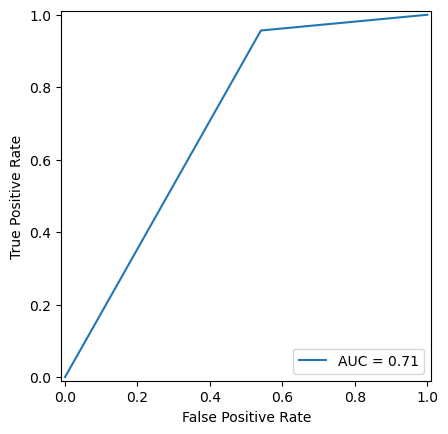

In [10]:
from sklearn.metrics import roc_curve,auc,RocCurveDisplay
fpr,tpr,thresholds=roc_curve(y_test,ypred_test)
roc_auc=auc(fpr,tpr)
RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc).plot()

In [11]:
from sklearn.metrics import roc_auc_score
print('AUC score:',roc_auc_score(y_test,ypred_test))

AUC score: 0.7079905992949471


# KNN

In [12]:
estimator=KNeighborsClassifier()
param_grid={'n_neighbors': list(range(1,50)),'p':[1,2]}
knn_grid=GridSearchCV(estimator,param_grid,scoring='accuracy',cv=5)
knn_grid.fit(X_train,y_train)
knn_grid.best_params_

{'n_neighbors': 13, 'p': 1}

In [13]:
knn_grid.best_estimator_

KNeighborsClassifier(n_neighbors=13, p=1)

In [14]:
knn_model=knn_grid.best_estimator_
knn_model.fit(X_train,y_train)

ypred_train=knn_model.predict(X_train)
print('Train accuracy:',accuracy_score(y_train,ypred_train))

print('CV score:',cross_val_score(knn_model,X_train,y_train,cv=5,scoring='accuracy').mean())

ypred_test=knn_model.predict(X_test)
print('Test accuracy:',accuracy_score(y_test,ypred_test))

Train accuracy: 0.7683215130023641
CV score: 0.742296918767507
Test accuracy: 0.6981132075471698


# SVM

In [ ]:
estimator=SVC()
param_grid={'C':[0.1],'kernel':['linear']}
svm_grid=GridSearchCV(estimator,param_grid,scoring='accuracy',cv=5)
svm_grid.fit(X_train,y_train)
svm_grid.best_params_

In [ ]:
svm_model=svm_grid.best_estimator_
svm_model.fit(X_train,y_train)

ypred_train=svm_model.predict(X_train)
print('Train accuracy:',accuracy_score(y_train,ypred_train))

print('CV score:',cross_val_score(svm_model,X_train,y_train,cv=5,scoring='accuracy').mean())

ypred_test=svm_model.predict(X_test)
print('Test accuracy:',accuracy_score(y_test,ypred_test))

# Decision Tree Classifier

In [15]:
model=DecisionTreeClassifier(random_state=True)
model.fit(X_train,y_train)

DecisionTreeClassifier(random_state=True)

In [16]:
y_train.value_counts()

Loan_Status
1    297
0    126
Name: count, dtype: int64

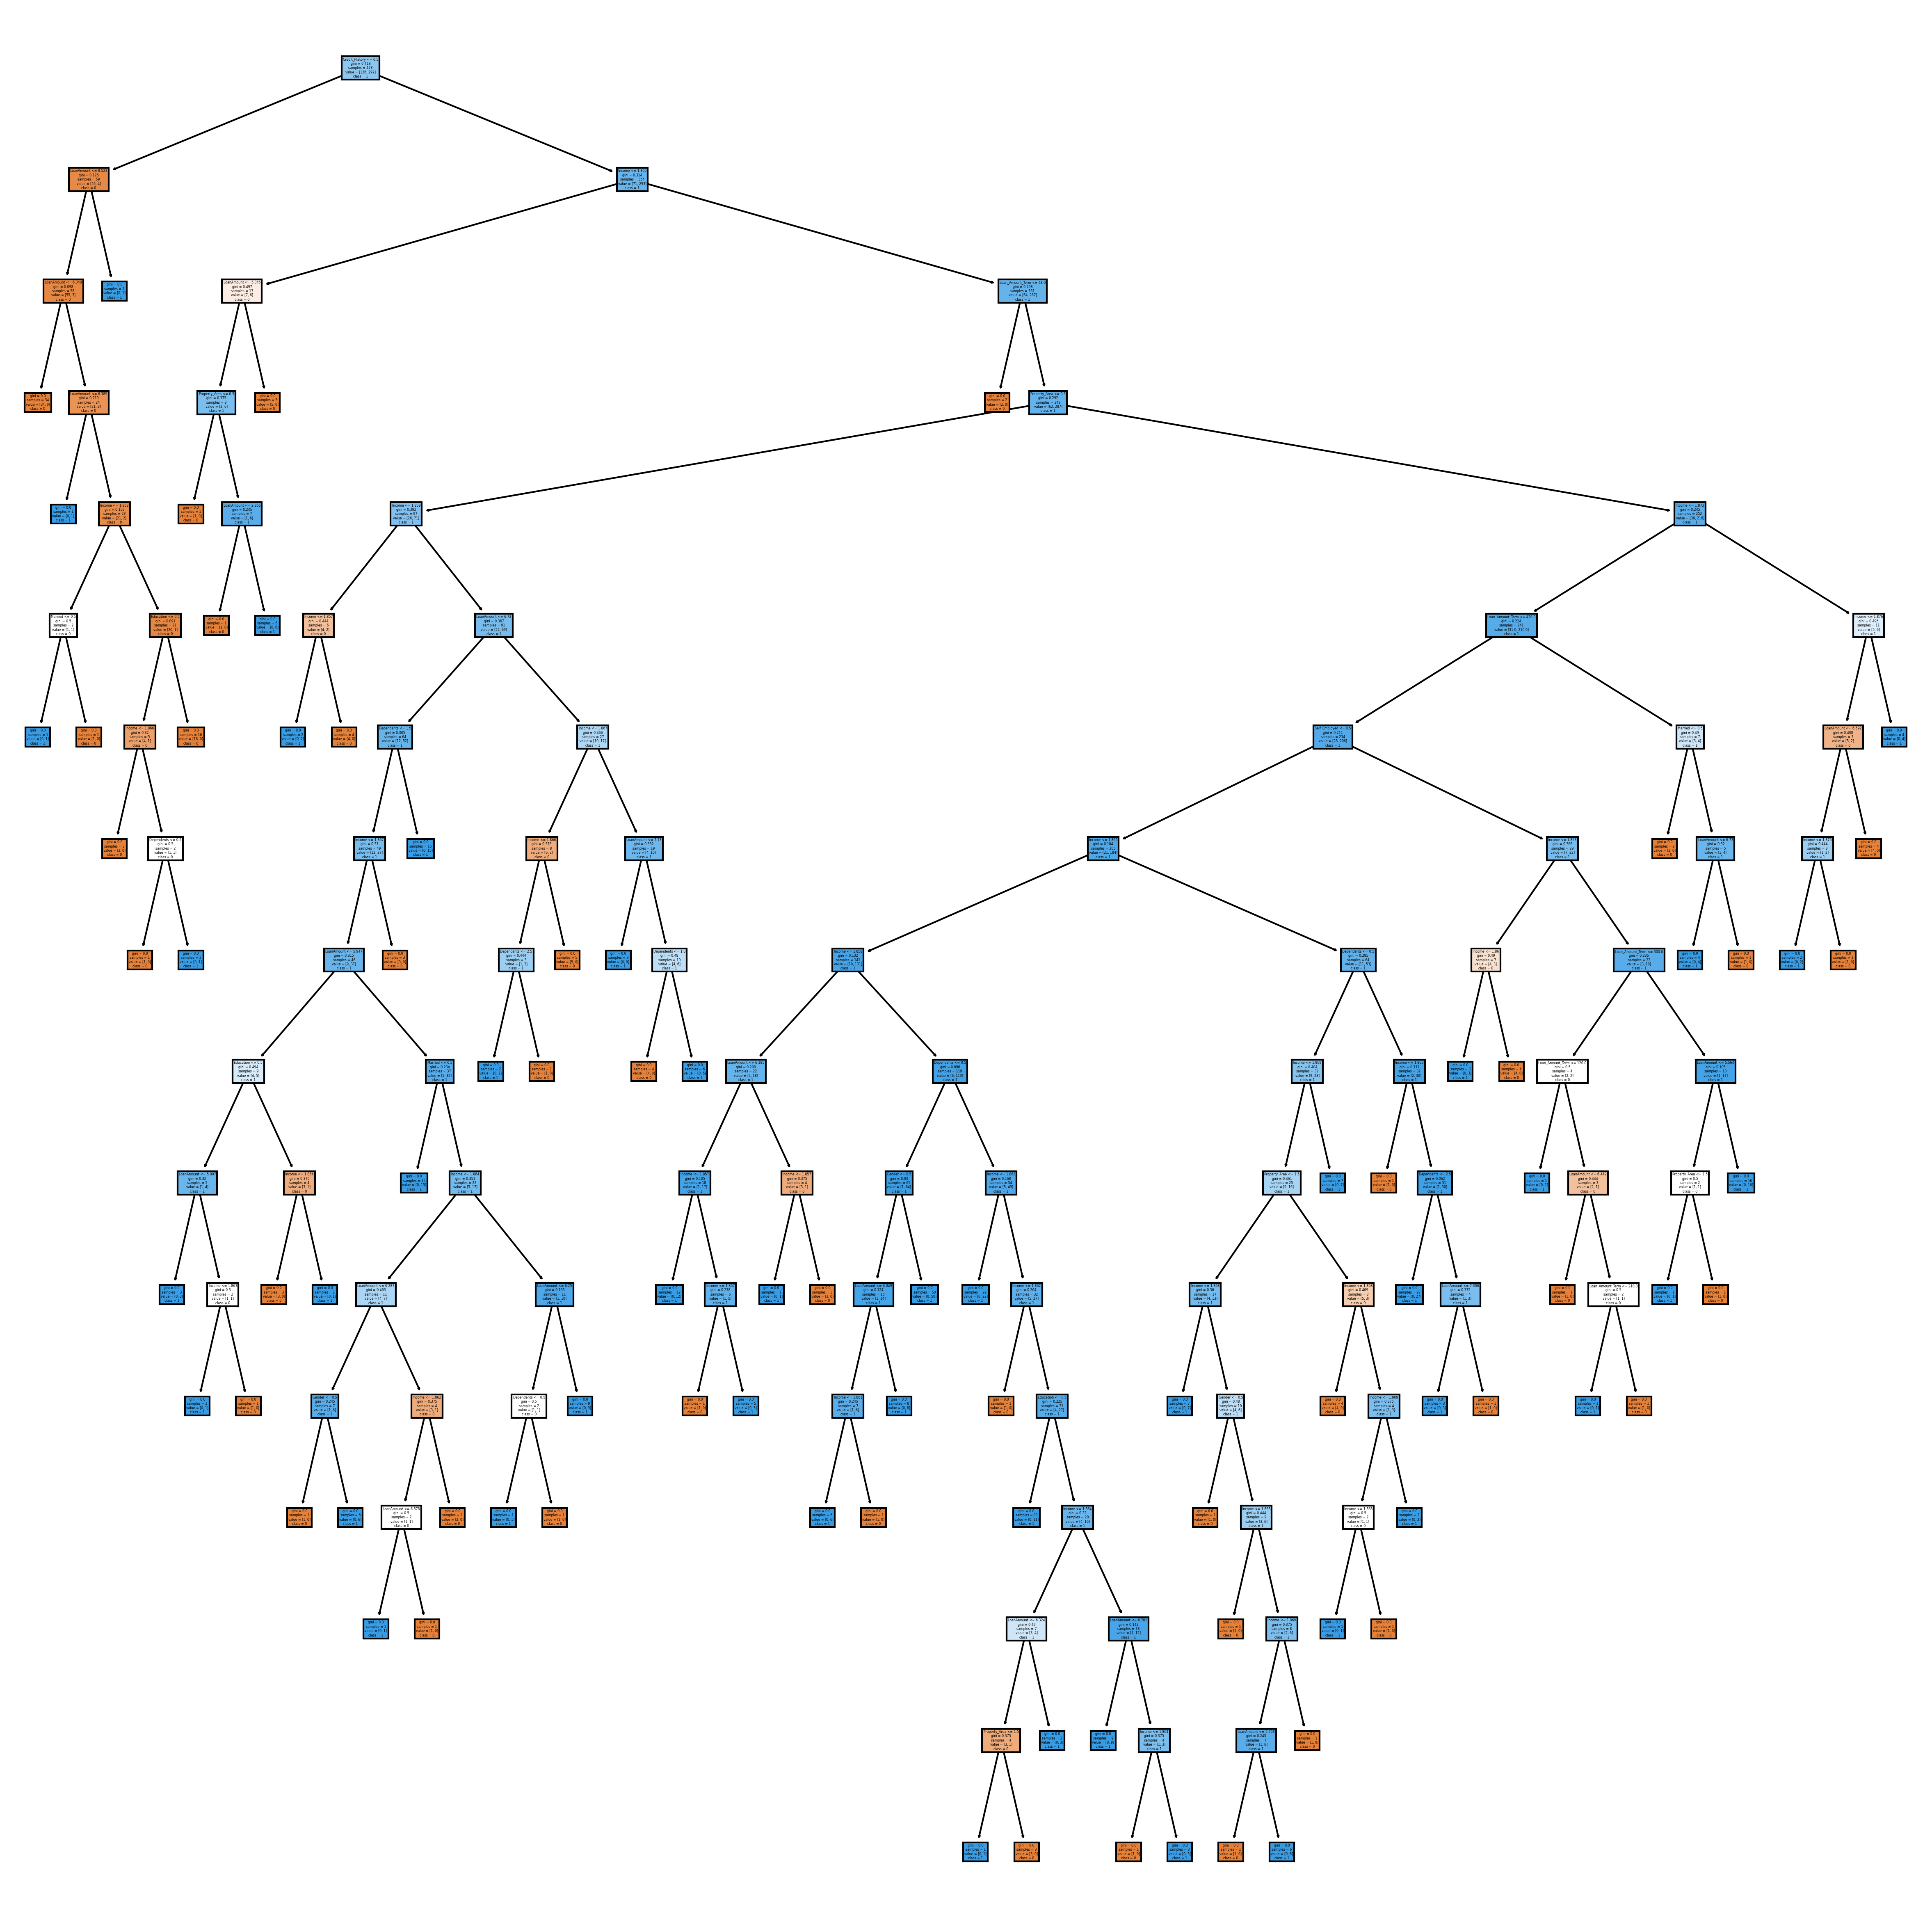

In [17]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,20),dpi=300)
plot_tree(model,filled=True,feature_names=X_train.columns.tolist(),class_names=['0','1'])
plt.show()

In [18]:
estimator=DecisionTreeClassifier(random_state=True)
param_grid={'criterion':['gini','entropy'],
           'max_depth':list(range(1,16))}
dt_grid=GridSearchCV(estimator,param_grid,scoring='accuracy',cv=5)
dt_grid.fit(X_train,y_train)
dt=dt_grid.best_estimator_
dt

DecisionTreeClassifier(max_depth=1, random_state=True)

In [19]:
feats_dt=pd.DataFrame(data=dt.feature_importances_,
                     index=X.columns,
                     columns=['Importance'])
important_features_dt=feats_dt[feats_dt['Importance']>0].index.tolist()
important_features_dt

['Credit_History']

In [20]:
X_train_dt=X_train[important_features_dt]
X_test_dt=X_test[important_features_dt]

dt=dt_grid.best_estimator_
dt.fit(X_train_dt,y_train)

ypred_train=dt.predict(X_train_dt)
ypred_test=dt.predict(X_test_dt)

print('Train accuracy:',accuracy_score(y_train,ypred_train))
print('CV score:',cross_val_score(dt,X_train_dt,y_train,cv=5,scoring='accuracy').mean())
print('Test accuracy:',accuracy_score(y_test,ypred_test))

Train accuracy: 0.8226950354609929
CV score: 0.8227731092436976
Test accuracy: 0.7830188679245284


In [21]:
%%timeit
dt.fit(X_train_dt,y_train)

4.43 ms ± 229 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# save best model

In [22]:
from joblib import dump
dump(dt,'loan.joblib')

['loan.joblib']

# predict on new data

In [23]:
input_data={'Loan_ID':'LP002991',
           'Gender':'Male',
           'Married':'No',
           'Dependents':1,
           'Education':'Graduate',
           'Self_Employed':'yes',
           'ApplicantIncome':1000,
           'CoapplicantIncome':0,
           'LoanAmount':100,
           'Loan_Amount_Term':240,
           'Credit_History':'good',
           'Property_Area':'Urban'}

In [24]:
df=pd.DataFrame(input_data,index=[0])
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP002991,Male,No,1,Graduate,yes,1000,0,100,240,good,Urban


**Apply data preprocessing on the future data**

In [25]:
df.drop(columns=['Loan_ID'],inplace=True)
df['Income']=df['ApplicantIncome']+df['CoapplicantIncome']
df.drop(columns=['ApplicantIncome','CoapplicantIncome'],inplace=True)

df['Dependents']=df['Dependents'].fillna(0)
df['Gender']=df['Gender'].fillna(df['Gender'].mode()[0])
df['Married']=df['Married'].fillna(df['Married'].mode()[0])
df['Self_Employed']=df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])

df=df.dropna(subset=['Income','LoanAmount','Loan_Amount_Term','Credit_History'])
df['Dependents']=df['Dependents'].astype('int')
df['Loan_Amount_Term']=df['Loan_Amount_Term'].astype('int')



df['Gender']=df['Gender'].replace({'Male':1,'Female':0})
df['Married']=df['Married'].replace({'Yes':1,'No':0})
df['Education']=df['Education'].replace({'Graduate':1,'Not Graduate':0})
df['Self_Employed']=df['Self_Employed'].replace({'Yes':1,'No':0})
df['Property_Area']=df['Property_Area'].replace({'Rural':0,'Semiurban':1,'Urban':2})
df['Credit_History']=df['Credit_History'].replace({'good':1,'bad':0})


x_new=df
x_new

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Income
0,1,0,1,1,yes,100,240,1,2,1000


In [26]:
df['Gender']=df['Gender'].replace({'Male':1,'Female':0})
df['Married']=df['Married'].replace({'Yes':1,'No':0})
df['Education']=df['Education'].replace({'Graduate':1,'Not Graduate':0})
df['Self_Employed']=df['Self_Employed'].replace({'Yes':1,'No':0})
df['Property_Area']=df['Property_Area'].replace({'Rural':0,'Semiurban':1,'Urban':2})
df['Credit_History']=df['Credit_History'].replace({'good':1,'bad':0})


x_new=df
x_new

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Income
0,1,0,1,1,yes,100,240,1,2,1000


In [27]:
# select important features of your best model
x_new=x_new[important_features_dt]
# predict using best model
print(dt.predict(x_new))

[1]
